# Tema 7: Perceptron multistrat antrenat cu Pytorch

## Descrierea temei
Implementati un model de perceptron multistrat pentru clasificarea celor 10 clase din setul [Fashion MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist).

Puteti reutiliza si adapta cod din exemplul Pytorch pentru regresia logistica binara, din tema 5 (săptămâna 19 noiembrie - 25 noiembrie, de pe platforma elearning).

Modificarile pe care trebuie sa le aveti in vedere sunt:
1. In definirea lui Dataset nu se mai face filtrare dupa clasele pozitive si negative; se lasa toate datele
1. Functia de eroare `loss_fn` este `torch.nn.CrossEntropyLoss`.



## Suplimentar (si obligatoriu)
1. Pe un alt grafic sa se prezinte: accuratetea pe setul de antrenare si pe setul de testare, la finalul fiecarei epoci (ambele scoruri pe acelasi grafic, cu legenda).
1. Sa se calculeze si afiseze matricea de confuzie (puteti folosi [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)).

## Suplimentar (optional)

1. Pe un grafic sa se prezinte loss-ul la finalul fiecarei epoci, pe setul de antrenare. Functia de loss este aceeasi ca in logistic regression, cazul multinomial
1. Implementati modificare de ponderi folosind metoda momentum.
1. Matricea de confuzie ca procent + colorare heatmap.

# Predarea temei

Predarea acestei aplicatii se va face  in săptămâna  **18-22 decembrie**, în seara dinaintea laboratorului, ora 20, in cadrul temei 7 de pe platforma.
Cerinte si precizari:
1. Studentii se pot consulta intre ei, dar rezolvarile vor fi individuale. Necunoasterea codului prezentat inseamna nota 1 pentru tema curenta.

2. Se se faca adnotari de tipuri pentru variabilele folosite, parametrii de intrare ai functiilor si tipurile de retur. Neindeplinirea acestei cerinte duce la injumatatirea notei.

# Implementarea temei

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/laborator10

/content/drive/MyDrive/laborator10


Epoch [1/50], Loss: 0.2795926630496979
Train Accuracy at the end of Epoch 1: 84.17666666666666%
Accuracy on the test set: 84.14%
Epoch [2/50], Loss: 0.26006948947906494
Train Accuracy at the end of Epoch 2: 86.485%
Accuracy on the test set: 86.39%
Epoch [3/50], Loss: 0.2689071297645569
Train Accuracy at the end of Epoch 3: 87.83%
Accuracy on the test set: 87.05000000000001%
Epoch [4/50], Loss: 0.24976298213005066
Train Accuracy at the end of Epoch 4: 87.79666666666667%
Accuracy on the test set: 87.15%
Epoch [5/50], Loss: 0.688861072063446
Train Accuracy at the end of Epoch 5: 88.63666666666667%
Accuracy on the test set: 87.82%
Epoch [6/50], Loss: 0.278390109539032
Train Accuracy at the end of Epoch 6: 89.58666666666667%
Accuracy on the test set: 88.28%
Epoch [7/50], Loss: 0.28761863708496094
Train Accuracy at the end of Epoch 7: 89.42999999999999%
Accuracy on the test set: 88.02%
Epoch [8/50], Loss: 0.30125004053115845
Train Accuracy at the end of Epoch 8: 90.16666666666666%
Accuracy o

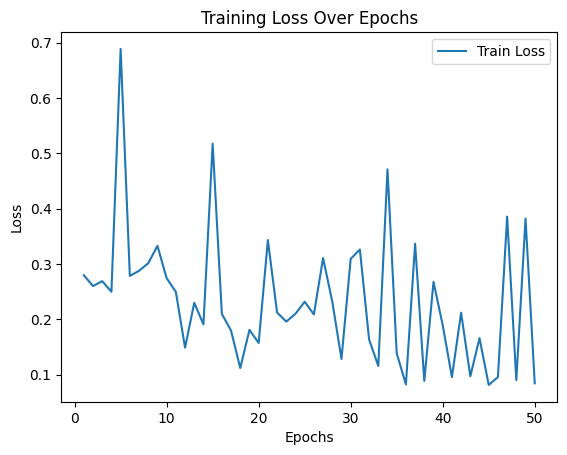

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from typing import Tuple, List

class FashionMNISTDataset(Dataset):
    def __init__(self, path_csv: str):
        """
        Initializează setul de date Fashion MNIST.

        :param path_csv: Calea către fișierul CSV care conține datele Fashion MNIST
        """
        super(FashionMNISTDataset, self).__init__()
        assert os.path.exists(path_csv) and os.path.isfile(path_csv), f'Calea {path_csv} nu indică spre un fișier'

        # Citim datele din fișier și specificăm tipul de date, skiprows=1 pentru a sari primul rând (header-ul)
        self.data: np.ndarray = pd.read_csv(path_csv, header=None, dtype=np.float32, skiprows=1).values

        # Transformăm valorile pixelilor în intervalul [0, 1]
        self.x: torch.Tensor = torch.Tensor(self.data[:, 1:]) / 255

        # Etichetele de clasă (0-9)
        self.y: torch.Tensor = torch.Tensor(self.data[:, 0])

    def __len__(self) -> int:
        """
        Returnează lungimea setului de date.

        :return: Numărul de exemple din set
        """
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returnează o pereche (intrare, etichetă) pentru un anumit index.

        :param index: Indexul exemplelor din set
        :return: O pereche (intrare, etichetă)
        """
        return self.x[index, :], self.y[index]

class MLP(nn.Module):
    def __init__(self, input_size: int = 28*28, hidden_size: int = 128, num_classes: int = 10):
        """
        Model de perceptron multistrat (MLP).

        :param input_size: Dimensiunea unui vector de intrare
        :param hidden_size: Dimensiunea stratului ascuns
        :param num_classes: Numărul de clase în setul de date
        """
        super(MLP, self).__init__()
        self.input_size: int = input_size
        self.hidden_size: int = hidden_size
        self.num_classes: int = num_classes

        # Strat ascuns
        self.hidden_layer: nn.Linear = nn.Linear(input_size, hidden_size)
        self.relu: nn.ReLU = nn.ReLU()

        # Strat de ieșire
        self.output_layer: nn.Linear = nn.Linear(hidden_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Propagarea înainte prin model.

        :param x: Datele de intrare
        :return: Rezultatul procesării datelor prin model
        """
        x = self.hidden_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

# Setul de date pentru Fashion MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset: FashionMNISTDataset = FashionMNISTDataset('./data/fashion-mnist_train.csv')
test_dataset: FashionMNISTDataset = FashionMNISTDataset('./data/fashion-mnist_test.csv')

# DataLoader pentru seturile de date
batch_size: int = 32
train_loader: DataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader: DataLoader = DataLoader(test_dataset, batch_size=batch_size)

# Modelul de perceptron multistrat
mlp_model: MLP = MLP(input_size=28*28, hidden_size=128, num_classes=10)

# Optimizatorul - Stochastic Gradient Descent (SGD) cu momentum
#
optimizer: optim.SGD = optim.SGD(mlp_model.parameters(), lr=0.01, momentum=0.9)
#optimizer: optim.Adam = optim.Adam(mlp_model.parameters(), lr=0.01, betas=(0.9, 0.999))
#optimizer: optim.Adam = optim.Adam(mlp_model.parameters(), lr=0.01)
#optimizer: optim.SGD = optim.SGD(mlp_model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

# Criteriul de pierdere - CrossEntropyLoss pentru clasificare multi-clasă
criterion: nn.CrossEntropyLoss = nn.CrossEntropyLoss()

# Antrenarea modelului
num_epochs: int = 50
train_accuracies: List[float] = []  # Lista pentru a stoca acuratețea pe setul de antrenare
test_accuracies: List[float] = []   # Lista pentru a stoca acuratețea pe setul de testare
train_losses: List[float] = []  # Lista pentru a stoca pierderile pe setul de antrenare


for epoch in range(num_epochs):
    for data, labels in train_loader:
        data: torch.Tensor = data.view(-1, 28*28)
        optimizer.zero_grad()
        outputs: torch.Tensor = mlp_model(data)
        labels = labels.long()
        loss: torch.Tensor = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

    # Evaluarea pe setul de antrenare la finalul fiecărei epoci
    train_correct: int = 0
    train_total: int = 0
    with torch.no_grad():
        for data, labels in train_loader:
            data: torch.Tensor = data.view(-1, 28*28)
            outputs: torch.Tensor = mlp_model(data)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

    train_accuracy: float = train_correct / train_total
    train_accuracies.append(train_accuracy)
    print(f'Train Accuracy at the end of Epoch {epoch+1}: {100 * train_accuracy}%')

    # Evaluarea pe setul de testare
    correct: int = 0
    total: int = 0
    predictions_mlp: List[int] = []
    with torch.no_grad():
        for data, labels in test_loader:
            data: torch.Tensor = data.view(-1, 28*28)
            outputs: torch.Tensor = mlp_model(data)

            # Alegem clasa cu cea mai mare probabilitate pentru fiecare intrare
            _, predicted = torch.max(outputs.data, 1)

            # Salvăm clasele prezise într-o listă pentru analize ulterioare
            predictions_mlp.extend(predicted.tolist())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy: float = correct / total
    test_accuracies.append(accuracy)
    print(f'Accuracy on the test set: {100 * accuracy}%')

# Trasare grafic pentru pierderile pe setul de antrenare la finalul fiecărei epoci
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

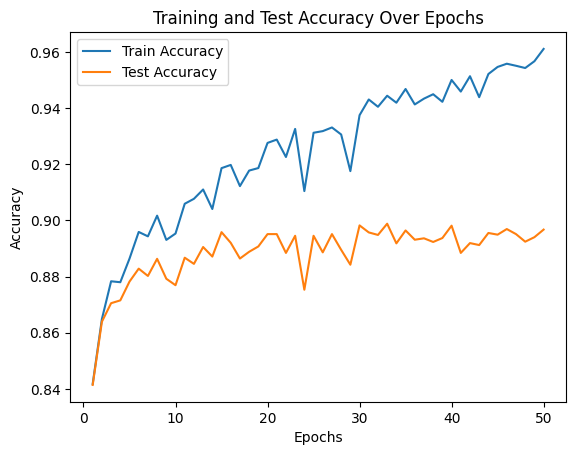

In [ ]:
epochs_range = range(1, num_epochs + 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()


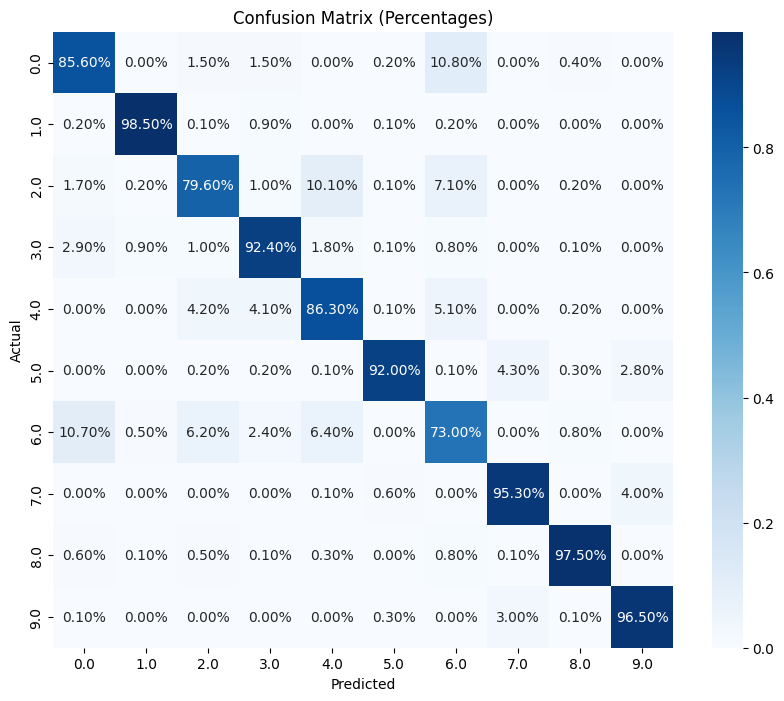

In [ ]:
# Calculul matricei de confuzie
conf_matrix = confusion_matrix(test_dataset.y.numpy(), predictions_mlp)

# Calculul procentelor pentru fiecare clasă
row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_percent = conf_matrix / row_sums

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=np.unique(test_dataset.y.numpy()),
            yticklabels=np.unique(test_dataset.y.numpy()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentages)')
plt.show()